In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)

C:\Users\omkar.karve\AppData\Roaming\Python\Python37\site-packages\requests\__init__.py:80: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


TF version: 2.1.0
TFP version: 0.8.0-rc0


In [2]:
from tensorflow.compat.v1 import InteractiveSession # This is needed to run on Windows 10 laptop with Cuda
# This is needed to run on Windows 10 laptop with Cuda
print(tf.__version__)

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2.1.0


# Probabilistic layers and Bayesian neural networks

## Coding tutorials
#### [1. The DistributionLambda layer](#coding_tutorial_1)
#### [2. Probabilistic layers](#coding_tutorial_2)
#### [3. The DenseVariational layer](#coding_tutorial_3)
#### [4. Reparameterization layers](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## The `DistributionLambda` layer

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#### Create a probabilistic model using the `DistributionLambda` layer

Create a model whose first layer represents:

$$
y = \text{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.
$$

## Class work

In [ ]:
# DO NOT RUN
# Introduction to Distributionlambda layer

#simple model
model = Sequential([
                    Dense(1,input_shape=(2,))]) #No activation function
model.compile(loss='mse', optimizer='rmsprop')
model.fit(x_train,y_train, epochs=10)

# y = <x, w> + eps          here eps is noise.
# eps ~ N(0, sigma^2)
# theta = (x,b)
# theta^X = argmax_{theta} P(D| theta)


In [ ]:
# DO NOT RUN
# model with probabilistic layer
# The output of the prev layer defines the mean of the distributionlambda layer
# the argument to the distributionlambda layer should be a function that returns
# a distribution object. Here is the lambda function takes input t which is the output
# of the previous layer.
# 
model = Sequential([
                    Dense(1,input_shape=(2,))]) 
                    tfpl.DistributionLambda(
                        lambda t: tfd.Normal(loc=t,scale=1))

model(x_sample) #x_sample: (16,2)


# This model returns
# tfp.distributions.Normal("sequential_distribution_lambda_Normal", batch_shape=[16,1], event_shape=[],dtype=float32)
# Normal distribution is a univariate so event shape is scalar. 16 is batch size.

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer='rmsprop')
model.fit(x_train,y_train, epochs=10)

model(x_test).sample()
#model(x_test).mean()

In [ ]:
# Sometimes we want to have the output be a tensor so it can be fed further downstream
# convert_to_tensor_fn is the 
model = Sequential([
                    Dense(1,input_shape=(2,))]) 
                    tfpl.DistributionLambda(
                        lambda t: tfd.Normal(loc=t,scale=1),
                    convert_to_tensor_fn=tfd.Distribution.sample)
                                        #tfd.Distribution.mean
                                        #tfd.Distribution.mode

## Lab

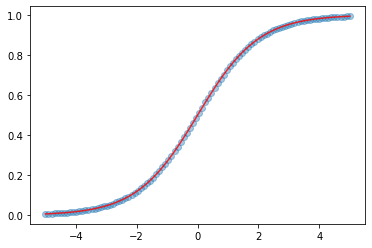

In [4]:
# Create a sigmoid model, first deterministic, then probabilistic

model = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
          kernel_initializer=tf.constant_initializer(1),
          bias_initializer=tf.constant_initializer(0)),
])

# Plot the function
x_plot = np.linspace(-5, 5, 100)
plt.scatter(x_plot, model.predict(x_plot), alpha=0.4)
plt.plot(x_plot, 1/(1 + np.exp(-x_plot)), color='r', alpha=0.8)
plt.show()

In [5]:
# Create a constant input for this model

x = np.array([[0]])
x

array([[0]])

In [6]:
# Explore the feedforward object...
y_model = model(x)
y_model


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5]], dtype=float32)>

In [8]:
# ... and its behaviour under repeated calls

for _ in range(5):
    print(model.predict(x)) #As it prints 0.5 5 times, it is a deterministic model

[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]


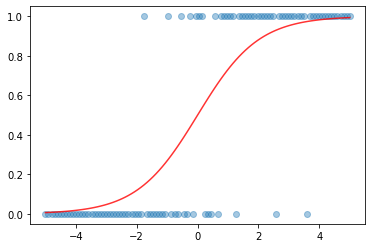

In [18]:
# Create a sigmoid model, first deterministic, then probabilistic

model = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
          kernel_initializer=tf.constant_initializer(1),
          bias_initializer=tf.constant_initializer(0)),
    tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs=t),
                           convert_to_tensor_fn=tfd.Distribution.sample)
    #if convert_to_tensor_fn is changed to .mean instead of .mean, it is same as the deterministic model above.
])

# Plot the function
x_plot = np.linspace(-5, 5, 100)
plt.scatter(x_plot, model.predict(x_plot), alpha=0.4)
plt.plot(x_plot, 1/(1 + np.exp(-x_plot)), color='r', alpha=0.8)
plt.show()

In [19]:
# Create a constant input for this model

x = np.array([[0]])
x

array([[0]])

In [20]:
# Explore the feedforward object...
y_model = model(x)
y_model

<tfp.distributions.Bernoulli 'sequential_3_distribution_lambda_2_Bernoulli' batch_shape=[1, 1] event_shape=[] dtype=int32>

In [21]:
# ... and its behaviour under repeated calls

for _ in range(5):
    print(model.predict(x)) #because the output is sampled from the Bernoulli dist, the output is diff everytime

[[0]]
[[1]]
[[1]]
[[0]]
[[1]]


#### Use the forward model to create probabilistic training data


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



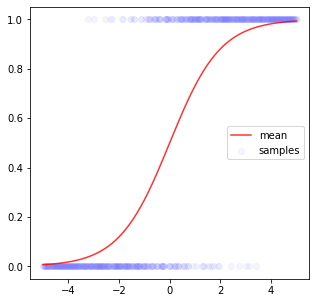

In [22]:
# Use the model to create 500 training points

x_train = np.linspace(-5, 5, 500)[:, np.newaxis]
y_train = model.predict(x_train)

# Plot the data and the mean of the distribution
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x_train, y_train, alpha=0.04, color='blue', label='samples')
ax.plot(x_train, model(x_train).mean().numpy().flatten(), 
        color='red', alpha=0.8, label='mean')
ax.legend()
plt.show()

#### Create a new probabilistic model with the wrong weights

In [25]:
# Create a new version of the model, with the wrong weights

model_untrained = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
          kernel_initializer=tf.constant_initializer(2),
          bias_initializer=tf.constant_initializer(2)),
    tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs=t),
                           convert_to_tensor_fn=tfd.Distribution.sample)
    #if convert_to_tensor_fn is changed to .mean instead of .mean, it is same as the deterministic model above.
])

#### Train the new model with the negative loglikelihood

In [28]:
# Define negative loglikelihood, which we will use for training

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [29]:
# Compile untrained model

model_untrained.compile(loss = nll, optimizer=RMSprop(learning_rate=0.01))


In [30]:
# Train model, record weights after each epoch

epochs = [0]
training_weights = [model_untrained.weights[0].numpy()[0, 0]]
training_bias = [model_untrained.weights[1].numpy()[0]]
for epoch in range(100):
    model_untrained.fit(x=x_train, y=y_train, epochs=1, verbose=False)
    epochs.append(epoch)
    training_weights.append(model_untrained.weights[0].numpy()[0, 0])
    training_bias.append(model_untrained.weights[1].numpy()[0])

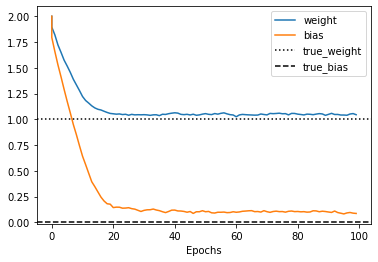

In [31]:
# Plot the model weights as they train, converging to the correct values

plt.plot(epochs, training_weights, label='weight')
plt.plot(epochs, training_bias, label='bias')
plt.axhline(y=1, label='true_weight', color='k', linestyle=':')
plt.axhline(y=0, label='true_bias', color='k', linestyle='--')
plt.xlabel('Epochs')
plt.legend()
plt.show() 

# As there are not enought training points (only 500) the weights and biases do not
# converge to true values. This is an example of the epistemic uncertainty.

## Classwork - Probabilistic Layers

In [ ]:
# DO NOT RUN
model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(2), #(batch_size,2)
    tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=t[...,:1], #first unit from the previous layer
                                                                               # is used for loc (:1)
                                                                scale=tf.math.softplus(t[...,1:]))
                                                                               #second unit from the previous layer
                                                                               # is used for scale (1:)
                                                                               # softplus converts any values to strictly positive
                                                     )])
model(x_sample) # x_sample: (16,2)
    # tfp.distributions.Independent(
    # "sequential_distribution_lambda_Independentsequential_distribution_lambda_Normal",
    #  batch_shape=[16], event_shape=[1],d_type=float32)

In [ ]:
# DO NOT RUN
model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(2), #(batch_size,2)
    tfpl.IndependentNormal(1) #same as before, the 1 argument is the event shape - means this layer needs two parameter
                              #to be defined, mean and std dev. Hence the prev dense layer has 2 units.
    )]
model(x_sample) # x_sample: (16,2)
    # tfp.distributions.Independent(
    # "model_normal_IndependentNormal_Independentmodel_normal_IndependentNormal_Normal",
    #  batch_shape=[16], event_shape=[1],d_type=float32)

In [ ]:
# DO NOT RUN
model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(4), # 2 for means and 2 for std dev in the next layer
    tfpl.IndependentNormal(2) # Here the event shape is 2. This can be 2 dimensional multivariate normal for the diagonal covariance matrix
    )]
    
model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(8), 
    tfpl.IndependentNormal([2,2]) 
    )]
    
model(x_sample) # x_sample: (16,2)
    # tfp.distributions.Independent(
    # "model_normal_IndependentNormal_Independentmodel_normal_IndependentNormal_Normal",
    #  batch_shape=[16], event_shape=[2,2],d_type=float32)

In [ ]:
# DO NOT RUN
# Previously the layer before the probabilistic layer had to ensure that the number of inputs
# match the event shape
event_shape = 2
model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(tfpl.IndependentNormal.params_size(event_shape)), # The params_size returns 4
    tfpl.IndependentNormal(event_shape,
                          convert_to_tensor_fn=tfd.Distribution.sample) 
    )]

In [ ]:
# DO NOT RUN
# This is a classifier model
# The one hot categorical layer directly outputs one hot cate dist object.
# this layer needs prev layer to output 10 units.
num_classes = 10

model = Sequential ([
    Conv2D(16,(3,3),activation='relu', input_shape=(32,32,3)),
    MaxPooling2D((3,3)),
    Flatten(),
    Dense(64,activation='relu'),
    Dense(tfpl.OneHotCategorical.params_size(num_classes)),
    tfpl.OneHotCategorical(num_classes)
])

model.comnpile(loss=lambda y_truemy_pred: -y_pred.log_prob(y_true)) # y_true needs to be a one hot vector.
model.fit(x_train,y_train,epochs=20)

model(x_test) #x_test: (1,32,32,3)
# tf.Tensor([[0.016 0.012 0.014 0.25 0.035 0.20
# 0.32 0.0027 0.10 0.018]], shape=(1,10),dtype=float32)

model(x_test).sample()
# tf.Tensor([[ 0 0 0 1 0 0 0 0 0 0]], shape(1,10),dtype=float32)

***
<a id="coding_tutorial_2"></a>
## Probabilistic layers

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#### Create data

The data you'll be working with is artifically created from the following equation:
$$ y_i = x_i + \frac{3}{10}\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

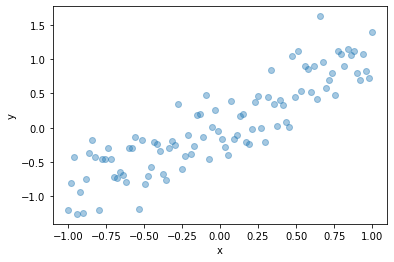

In [34]:
# Create and plot 100 points of training data

x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Deterministic linear regression with MSE loss

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


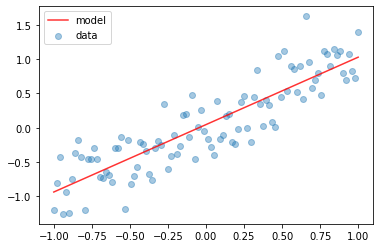

In [35]:
# Create and train deterministic linear model using mean squared error loss

# Create linear regression via Sequential model
model = Sequential([
    Dense(units=1, input_shape=(1,))
])
model.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model.summary()
model.fit(x_train, y_train, epochs=200, verbose=False)

# Plot the data and model
plt.scatter(x_train, y_train, alpha=0.4, label='data')
plt.plot(x_train, model.predict(x_train), color='red', alpha=0.8, label='model')
plt.legend()
plt.show()



#Disadvantages of linear regression. It fails to work out the aleatoric uncertainty.

In [36]:
# Examine the model predictions
x = np.array([[0]])
y_model = model(x)
y_model


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.04506347]], dtype=float32)>

#### Probabilistic linear regression with both user-defined and learned variance

In [38]:
# Create probabilistic regression with normal distribution as final layer
# Here in this version only the mean is being learnt
model = Sequential([
    Dense(units=1, input_shape=(1,)),
    tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=t,scale=1)))
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1)                 2         
_________________________________________________________________
distribution_lambda_4 (Distr ((None, 1), (None, 1))    0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [49]:
print(tfpl.IndependentNormal.params_size(1))

2


In [44]:
# Create probabilistic regression with normal distribution as final layer
# In this version the mean and std dev are both being learnt
event_shape = 1
model = Sequential([
    Dense(units=tfpl.IndependentNormal.params_size(event_shape), input_shape=(1,)), #tfpl.IndependentNormal.params_size(event_shape) = 2
    tfpl.IndependentNormal(event_shape)
    # The following is the same as above
    #tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(
    #    loc=t[...,:1],scale=tf.math.softplus(t[...,1:])
    #)))
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 2)                 4         
_________________________________________________________________
independent_normal (Independ ((None, 1), (None, 1))    0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Train model using the negative loglikelihood

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer = RMSprop(learning_rate=0.005))
model.fit(x_train,y_train, epochs=200, verbose=False)

In [47]:
# Examine the distribution created as a feedforward value
y_model=model(x)
y_model


<tfp.distributions.Independent 'sequential_7_independent_normal_IndependentNormal_Independentsequential_7_independent_normal_IndependentNormal_Normal' batch_shape=[1] event_shape=[1] dtype=float32>


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



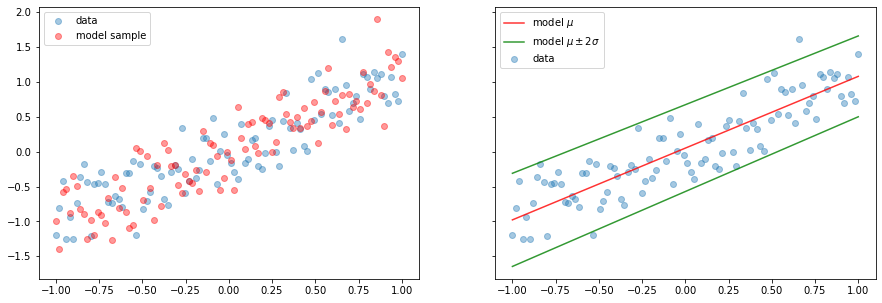

In [48]:
# Plot the data and a sample from the model

y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

#### Probabilistic linear regression with nonlinear learned mean & variance

Let's change the data to being nonlinear:
$$ y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

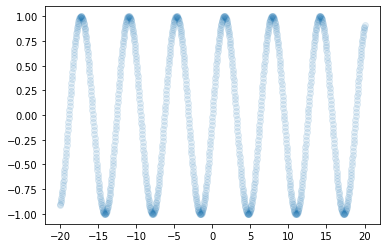

In [67]:
# Create and plot 10000 data points

x_train = np.linspace(-20, 20, 1000)[:, np.newaxis]
#y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]
y_train = np.sin(x_train)
plt.scatter(x_train, y_train, alpha=0.1)
plt.show()

In [68]:
# Create probabilistic regression: normal distribution with fixed variance

model = Sequential([
    Dense(input_shape=(1,), units=8, activation='sigmoid'),
    Dense(tfpl.IndependentNormal.params_size(event_shape=1)),
    tfpl.IndependentNormal(event_shape=1)
])
model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 18        
_________________________________________________________________
independent_normal_4 (Indepe ((None, 1), (None, 1))    0         
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [69]:
# Train model

model.fit(x_train, y_train, epochs=4000, verbose=False)
model.evaluate(x_train, y_train)

1000/1000 [==============================] - 0s 173us/sample - loss: 0.4392


0.43924449634552004


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



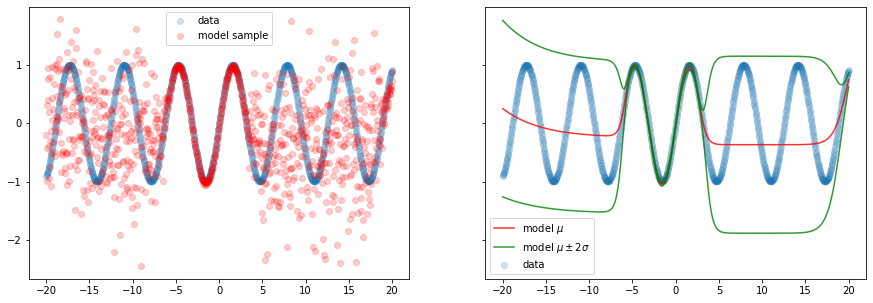

In [70]:
# Plot the data and a sample from the model

y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.2, label='data')
ax1.scatter(x_train, y_sample, alpha=0.2, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.2, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

## DenseVariational Layer - Classwork

In [ ]:
## DO NOT RUN
# Here only the aliatoric uncertainty is learnt
model = Sequential([
    Dense(16, activation='relu', input_shape=(8,0)),
    Dense(2),
    tfpl.IndependentNormal(1) # One dimensional event space, both mean and sigma are learnt
])

model.compile(loss = lambda y_true, y_pred: -y_pred.log_prob(y_true))
model.fit(x_train, y_train, epochs=200)

In [ ]:
## DO NOT RUN
# To learn the epistemic uncertainty, we need to learn the posterior distribution over the weights
# This prior distribution represents which model parameters are likely before we have seen any data
# Standard assumption is that the prior distribution is a spherical Gaussian i.e. an independent normal dist for each
# weight and bias all with equal variance
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    # Kernel_size: no of params in the dense layer weights matrix
    # returns a callable object - lambda function takes in tensor t and returns
    # an independent normal distribution with zero mean and variance 1
    # this dist is the prior over the dense layer params
    # input t is not used. Prior has no trainable parameters.
    return lambda t: tfd.Independent(tfd.Normal(loc=tf.zeros(n,dtype=dtype),scale=1),
                                    reinterpreted_batch_size=1)


# The callable object takes a tensor input and returns a distribution object 
# both functions need to adhere to this specification.

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
        # returns a TensorFlow variable when called, regardless of the input
        tfpl.IndependentNormal(n, convert_to_tensor_fn=tfd.Distribution.sample)
    ])

# We are now using distributions for model weights instead of point estimates
    
model = Sequential([
    tfpl.DenseVariational(16, posterior, prior, kl_weight=1/N, #N is the size of the dataset
                         activation='relu', input_shape=(8,), kl_use_exact=True),
    tfpl.DenseVariational(2, posterior, prior, kl_weight=1/N, kl_use_exact=True),
    tfpl.IndependentNormal(1)
])
# objective is to maximize ELBO
# q = q(w | theta) -> this is the posterior distribution, here w = vector of all model weights 
# and theta is all the parameters (mean and variance) that parametrize the posterior
# Elbo is given by two terms - expected log likelihood of the data and KL divergence over posterior over prior
# (E_{w~ q}[log p[D | w]) - KL[q || p]]
# assuming IID data: = sum_i (E_{w~ q}[log p[D_i | w]) - KL[q || p]]

# For training this model we optimize the model using minibatches:
# N/B * sum_j (E_{w~ q}[log p[D_j | w]) - KL[q || p]]
# N/B is done because this is calculated only for a minibatch so we need to scaleup the first term to be unbiased
# N is the total datasize and B is the batch size.

# per example loss:
# 1/B * sum_j (E_{w~ q}[log p[D_j | w]) - 1/N * KL[q || p]]

model.compile(loss = lambda y_true, y_pred: -y_pred.log_prob(y_true))
model.fit(x_train, y_train, epochs=200)

***
<a id="coding_tutorial_3"></a>
## The `DenseVariational` layer

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#### Create linear data with Gaussian noise

The data you'll be working with is the same as you used before:
$$ y_i = x_i + \frac{3}{10}\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed. We'll be running a Bayesian linear regression on this data.

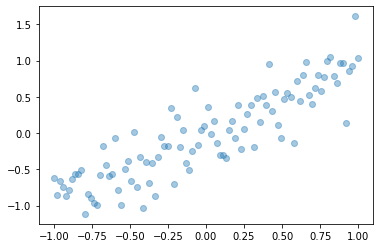

In [72]:
# Use the same data as before -- create and plot 100 data points

x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.4)
plt.show()

#### Create the prior and posterior distribution for model weights

In [79]:
# Define the prior weight distribution -- all N(0, 1) -- and not trainable
# When we estimate epistemic uncertainty we are trying to find a range of lines that estimate the data.

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = Sequential ([
        tfpl.DistributionLambda(
            lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n))
        )
    ])
    return prior_model

In [80]:
# Define variational posterior weight distribution -- multivariate Gaussian

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model

#### Aside: analytical posterior

In this tutorial, we're using a variational posterior because, in most settings, it's not possible to derive an analytical one. However, in this simple setting, it is possible. Specifically, running a Bayesian linear regression on $x_i$ and $y_i$ with $i=1, \ldots, n$ and a unit Gaussian prior on both $\alpha$ and $\beta$:

$$
y_i = \alpha + \beta x_i + \epsilon_i, \quad 
\epsilon_i \sim N(0, \sigma^2), \quad 
\alpha \sim N(0, 1), \quad 
\beta \sim N(0, 1)
$$

gives a multivariate Gaussian posterior on $\alpha$ and $\beta$:

$$
\begin{pmatrix}
\alpha \\
\beta
\end{pmatrix}
\sim
N(\mathbf{\mu}, \mathbf{\Sigma})
$$
where
$$ 
\mathbf{\mu}
= 
\mathbf{\Sigma} 
\begin{pmatrix}
\hat{n} \bar{y} \\
\hat{n} \overline{xy}
\end{pmatrix},
\quad
\mathbf{\Sigma} = 
\frac{1}{(\hat{n} + 1)(\hat{n} \overline{x^2} + 1) - \hat{n}^2 \bar{x}^2}
\begin{pmatrix}
\hat{n} \overline{x^2} + 1 & -\hat{n} \bar{x} \\
-\hat{n} \bar{x} & \hat{n} + 1
\end{pmatrix}.
$$

In the above, $\hat{n} = \frac{n}{\sigma^2}$ and $\bar{t} = \frac{1}{n}\sum_{i=1}^n t_i$ for any $t$. In general, however, it's not possible to determine the analytical form for the posterior. For example, in models with a hidden layer with nonlinear activation function, the analytical posterior cannot be determined in general, and variational methods as below are useful.

#### Create the model with `DenseVariational` layers

In [81]:
# Create linear regression model with weight uncertainty: weights are
# distributed according to posterior (and, indirectly, prior) distribution

model = Sequential([
    tfpl.DenseVariational(input_shape=(1,),
                         units=1,
                         make_prior_fn=prior,
                         make_posterior_fn=posterior,
                         kl_weight=1/x_train.shape[0],
                         kl_use_exact=True) #True means the KL is calculated analytically and not approximated
])

model.compile(loss=MeanSquaredError(),
             optimizer=RMSprop(learning_rate=0.005))
model.summary()
# The output has 5 parameters - this is because each weight is replaced by a distribution
# mean/variance for y intercept and slope and the covariance between them hence 5 parameters.

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_2 (DenseVa (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


#### Train model and inspect

In [82]:
# Fit the model, just like a deterministic linear regression

model.fit(x_train, y_train, epochs=500, verbose=False)

In [83]:
# Check out the parameters of the prior and posterior distribution

dummy_input = np.array([[0]])
model_prior = model.layers[0]._prior(dummy_input)
model_posterior = model.layers[0]._posterior(dummy_input)
print('prior mean:           ', model_prior.mean().numpy())
print('prior variance:       ', model_prior.variance().numpy())
print('posterior mean:       ', model_posterior.mean().numpy())
print('posterior covariance: ', model_posterior.covariance().numpy()[0])
print('                      ', model_posterior.covariance().numpy()[1])

prior mean:            [0. 0.]
prior variance:        [1. 1.]
posterior mean:        [ 0.90887046 -0.00884391]
posterior covariance:  [ 0.01875429 -0.00101848]
                       [-0.00101848  0.00546806]



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



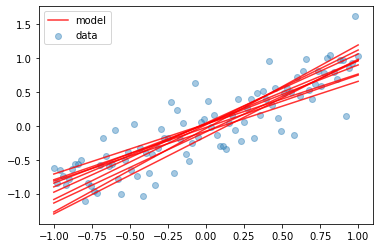

In [84]:
# Plot an ensemble of linear regressions, with weights sampled from
# the posterior distribution

plt.scatter(x_train, y_train, alpha=0.4, label='data')
for _ in range(10):
    y_model = model(x_train)
    if _ == 0:
        plt.plot(x_train, y_model, color='red', alpha=0.8, label='model')
    else:
        plt.plot(x_train, y_model, color='red', alpha=0.8)        
plt.legend()
plt.show()

#### Explore the effect of sample size

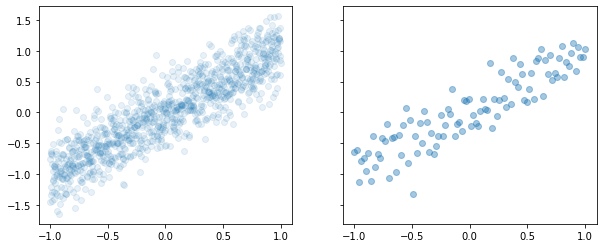

In [85]:
# Create two datasets, one with 1000 points, another with 100

x_train_1000 = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train_1000 = x_train_1000 + 0.3*np.random.randn(1000)[:, np.newaxis]

x_train_100 = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train_100 = x_train_100 + 0.3*np.random.randn(100)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
ax1.scatter(x_train_1000, y_train_1000, alpha=0.1)
ax2.scatter(x_train_100, y_train_100, alpha=0.4)
plt.show()

In [86]:
# Train a model on each dataset

model_1000 = Sequential([tfpl.DenseVariational(input_shape=(1,), 
                                               units=1,
                                               make_prior_fn=prior, 
                                               make_posterior_fn=posterior,
                                               kl_weight=1/1000)])

model_100 = Sequential([tfpl.DenseVariational(input_shape=(1,), 
                                              units=1,
                                              make_prior_fn=prior, 
                                              make_posterior_fn=posterior,
                                              kl_weight=1/100)])

model_1000.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model_100.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))

model_1000.fit(x_train_1000, y_train_1000, epochs=50, verbose=False)
model_100.fit(x_train_100, y_train_100, epochs=500, verbose=False)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



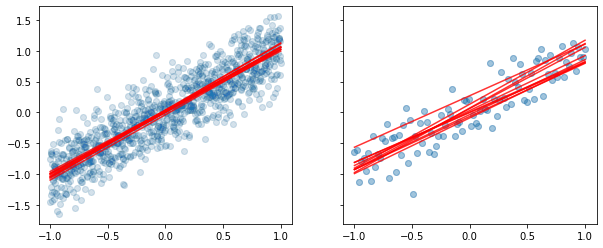

In [87]:
# Plot an ensemble of linear regressions from each model

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for _ in range(10):
    y_model_1000 = model_1000(x_train_1000)
    ax1.scatter(x_train_1000, y_train_1000, color='C0', alpha=0.02)
    ax1.plot(x_train_1000, y_model_1000, color='red', alpha=0.8)
    y_model_100 = model_100(x_train_100)
    ax2.scatter(x_train_100, y_train_100, color='C0', alpha=0.05)
    ax2.plot(x_train_100, y_model_100, color='red', alpha=0.8)
plt.show()

#### Put it all together: nonlinear probabilistic regression with weight uncertainty

Let's change the data to being nonlinear:
$$ y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

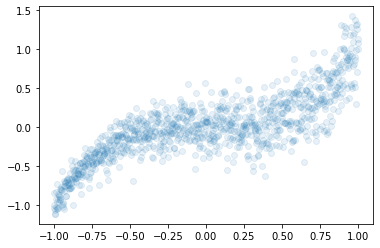

In [92]:
# Create and plot 1000 data points

x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.1)
plt.show()

In [93]:
# Create probabilistic regression with one hidden layer, weight uncertainty

model = Sequential([
    tfpl.DenseVariational(units=8,
                          input_shape=(1,),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0],
                          activation='sigmoid'),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0]),
    tfpl.IndependentNormal(1)
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_7 (DenseVa (None, 8)                 152       
_________________________________________________________________
dense_variational_8 (DenseVa (None, 2)                 189       
_________________________________________________________________
independent_normal_6 (Indepe ((None, 1), (None, 1))    0         
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [96]:
# Train the model

model.fit(x_train, y_train, epochs=1000, verbose=False)
model.evaluate(x_train, y_train)

1000/1000 [==============================] - 0s 122us/sample - loss: -0.0353


-0.035331659734249114

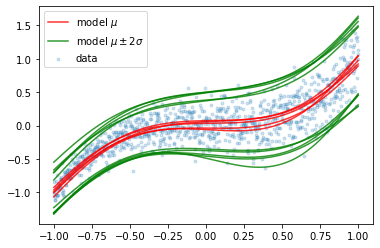

In [97]:
# Plot an ensemble of trained probabilistic regressions

plt.scatter(x_train, y_train, marker='.', alpha=0.2, label='data')
for _ in range(5):
    y_model = model(x_train)
    y_hat = y_model.mean()
    y_hat_m2sd = y_hat - 2 * y_model.stddev()
    y_hat_p2sd = y_hat + 2 * y_model.stddev()
    if _ == 0:
        plt.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
    else:
        plt.plot(x_train, y_hat, color='red', alpha=0.8)
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8)
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)        
plt.legend()
plt.show()

## Reparameterization layers - Class work

In [ ]:
# DO NOT RUN
# Conv2D and Dense layers have been replaced by reparameterization equivalents
# The background is the same as DenseVariational layer
model = Sequential([
    tfpl.Convolution2DReparameterization(16,[3,3],activation='relu', input_shape=(28,28,1),
                                        kernel_posterior_fn=tfpl.default_mean_field_normal(),
                                         #the posterior is being called as it returns a distribution
                                         kernel_prior_fn=tfpl.default_multivariate_normal_fn),
                                        
    MaxPool2D(3),
    Flatten(),
    tfpl.DenseReparameterizationa(tfpl.OneHotCatergorical.params_size(10)),
    tfpl.OneHotCategorical(10)
])

# The defaults for kernel_posterior or kernel_prior are of following type
# trainable is boolean, add_variable_fn used to create variables (add_weight method f the base layer)
def custom_multivariate_normal_fn(dtype,shape,name,trainable,add_variable_fn):
    normal=tfd.Normal(loc=tf.zeros(shape,dtype),scale=2*tf.ones(shape,dtype))
    batch_ndims=tf.size(normal.batch_shape_tensor())
    return tfd.Independent(normal,reinterpreted_batch_ndims=batch_ndims)

model = Sequential([
    tfpl.Convolution2DReparameterization(16,[3,3],activation='relu', input_shape=(28,28,1),
                                        kernel_posterior_fn=tfpl.default_mean_field_normal(),
                                         #the posterior is being called as it returns a distribution
                                         kernel_posterior_tensor_fn=tfd.Distribution.sample,
                                         kernel_prior_fn=tfpl.custom_multivariate_normal_fn,
                                         bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=True),
                                         #as is singular is set to true, this option makes bias to be a single point deterministic value
                                         # hence the posterior tensor is like sampling from one point so .sample and .mean would be the same
                                         bias_posterior_tensor_fn=tfd.Distribution.sample,
                                         
                                         bias_prior_fn=None,
                                         #This attempts to calc KLDiv analytically.
                                         kernel_divergence_fn=(lambda q,p,_:tfd.kl_divergence(q,p)/dataset_size)),
                                            
    MaxPool2D(3),
    Flatten(),
    tfpl.DenseReparameterizationa(tfpl.OneHotCatergorical.params_size(10)),
    tfpl.OneHotCategorical(10)
])

***
<a id="coding_tutorial_4"></a>
## Reparameterization layers

In [98]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop
import os
import numpy as np
import matplotlib.pyplot as plt

#### Load in the HAR dataset

You'll be working with the [Human Activity Recognition (HAR) Using Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. It consists of the readings from an accelerometer (which measures acceleration) carried by a human doing different activities. The six activities are walking horizontally, walking upstairs, walking downstairs, sitting, standing and laying down. The accelerometer is inside a smartphone, and, every 0.02 seconds (50 times per second), it takes six readings: linear and gyroscopic acceleration in the x, y and z directions. See [this link](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) for details and download. If you use it in your own research, please cite the following paper:

- Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013. 

The goal is to use the accelerometer data to predict the activity.

In [101]:
# Load the HAR dataset and create some data processing functions

# Function to load the data from file
def load_HAR_data():
    data_dir = 'data/HAR/'
    x_train = np.load(os.path.join(data_dir, 'x_train.npy'))[..., :6]
    y_train = np.load(os.path.join(data_dir, 'y_train.npy')) - 1
    x_test  = np.load(os.path.join(data_dir, 'x_test.npy'))[..., :6]
    y_test  = np.load(os.path.join(data_dir, 'y_test.npy')) - 1
    return (x_train, y_train), (x_test, y_test)

# Dictionary containing the labels and the associated activities
label_to_activity = {0: 'walking horizontally', 1: 'walking upstairs', 2: 'walking downstairs',
                     3: 'sitting', 4: 'standing', 5: 'laying'}

# Function to change integer labels to one-hot labels
def integer_to_onehot(data_integer):
    data_onehot = np.zeros(shape=(data_integer.shape[0], data_integer.max()+1))
    for row in range(data_integer.shape[0]):
        integer = int(data_integer[row])
        data_onehot[row, integer] = 1
    return data_onehot

# Load the data
(x_train, y_train), (x_test, y_test) = load_HAR_data()
y_train_oh = integer_to_onehot(y_train)
y_test_oh = integer_to_onehot(y_test)

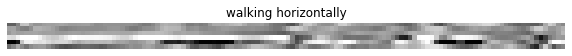

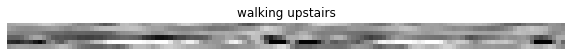

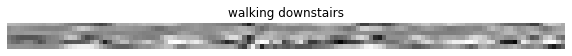

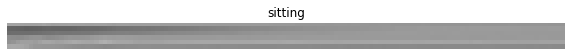

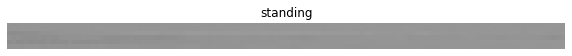

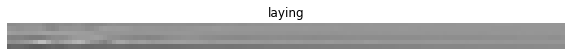

In [102]:
# Inspect some of the data by making plots

def make_plots(num_examples_per_category):
    for label in range(6):
        x_label = x_train[y_train[:, 0] == label]
        for i in range(num_examples_per_category):
            fig, ax = plt.subplots(figsize=(10, 1))
            ax.imshow(x_label[100*i].T, cmap='Greys', vmin=-1, vmax=1)
            ax.axis('off')
            if i == 0:
                ax.set_title(label_to_activity[label])
            plt.show()
        
make_plots(1)

#### 1D deterministic convolutional neural network

In [103]:
# Create standard deterministic model with:
# - Conv1D
# - MaxPooling
# - Flatten
# - Dense with Softmax

model = Sequential([
    Conv1D(input_shape=(128, 6), filters=8, kernel_size=16, activation='relu'),
    MaxPooling1D(pool_size=16),
    Flatten(),
    Dense(units=6, activation='softmax')
])
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 113, 8)            776       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 8)              0         
_________________________________________________________________
flatten (Flatten)            (None, 56)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 342       
Total params: 1,118
Trainable params: 1,118
Non-trainable params: 0
_________________________________________________________________


#### Probabilistic 1D convolutional neural network, with both weight and output uncertainty

In [111]:
# Create probablistic model with the following layers:
#  - Conv1D
#  - MaxPooling
#  - Flatten
#  - Dense
#  - OneHotCategorical

divergence_fn = lambda q,p,_: tfd.kl_divergence(q,p) / x_train.shape[0]

model = Sequential([
    tfpl.Convolution1DReparameterization(
        input_shape=(128,6), filters=8, kernel_size=16, activation='relu',
        kernel_prior_fn = tfpl.default_multivariate_normal_fn, #independent normal with non trainable as we dont learn anything in prior
        kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_divergence_fn=divergence_fn,
        bias_prior_fn = tfpl.default_multivariate_normal_fn, #independent normal with non trainable as we dont learn anything in prior
        bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn=divergence_fn,
    ),
    MaxPooling1D(pool_size=16),
    Flatten(),
    tfpl.DenseReparameterization(
        units=tfpl.OneHotCategorical.params_size(6), activation=None,
        kernel_prior_fn = tfpl.default_multivariate_normal_fn, #independent normal with non trainable as we dont learn anything in prior
        kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_divergence_fn=divergence_fn,
        bias_prior_fn = tfpl.default_multivariate_normal_fn, #independent normal with non trainable as we dont learn anything in prior
        bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn=divergence_fn,
    ),
    tfpl.OneHotCategorical(6)
])
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_reparameterization_2  (None, 113, 8)            1552      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 8)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 56)                0         
_________________________________________________________________
dense_reparameterization_1 ( (None, 6)                 684       
_________________________________________________________________
one_hot_categorical_1 (OneHo ((None, 6), (None, 6))    0         
Total params: 2,236
Trainable params: 2,236
Non-trainable params: 0
_________________________________________________________________


In [104]:
# Replace analytical Kullback-Leibler divergence with approximated one

def kl_approx(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

divergence_fn = lambda q, p, q_tensor : kl_approx(q, p, q_tensor) / x_train.shape[0]

In [112]:
# Compile the model using the negative loglikelihood

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll,
              optimizer=RMSprop(learning_rate=0.005),
              metrics=['accuracy'],
              experimental_run_tf_function=False)

In [113]:
# Train the model

model.fit(x_train, y_train_oh, epochs=20, verbose=False)
model.evaluate(x_train, y_train_oh)
model.evaluate(x_test, y_test_oh)

2947/2947 [==============================] - 0s 137us/sample - loss: 0.9878 - accuracy: 0.7234


[0.9877885309748622, 0.72344756]

#### Inspect model performance

In [114]:
# Define function to analyse model predictions versus true labels

def analyse_model_predictions(image_num):

    # Show the accelerometer data
    print('------------------------------')
    print('Accelerometer data:')
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(x_test[image_num].T, cmap='Greys', vmin=-1, vmax=1)
    ax.axis('off')
    plt.show()

    # Print the true activity
    print('------------------------------')
    print('True activity:', label_to_activity[y_test[image_num, 0]])
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities
    predicted_probabilities = np.empty(shape=(200, 6))
    for i in range(200):
        predicted_probabilities[i] = model(x_test[image_num][np.newaxis, ...]).mean().numpy()[0]
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(6)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(6)])
    # Make the plots
    fig, ax = plt.subplots(figsize=(9, 3))
    bar = ax.bar(np.arange(6), pct_97p5, color='red')
    bar[y_test[image_num, 0]].set_color('green')
    bar = ax.bar(np.arange(6), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],
                       rotation=45, horizontalalignment='right')
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

------------------------------
Accelerometer data:


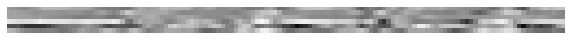

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



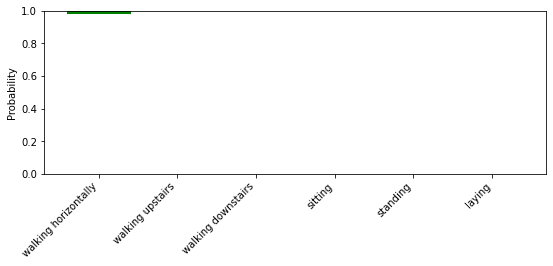

In [115]:
analyse_model_predictions(image_num=79)

------------------------------
Accelerometer data:


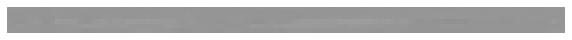

------------------------------
True activity: standing

------------------------------
Model estimated probabilities:


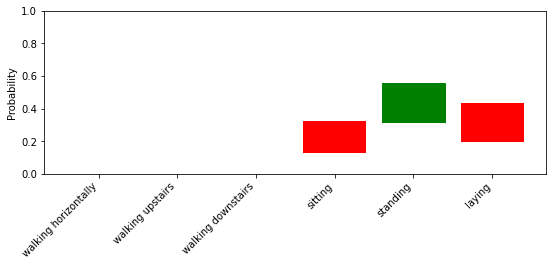

In [116]:
analyse_model_predictions(image_num=633)

------------------------------
Accelerometer data:


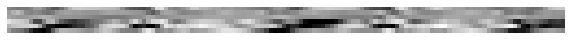

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:


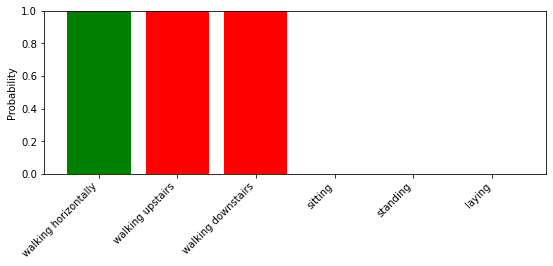

In [118]:
analyse_model_predictions(image_num=1137)